Vocab

In [4]:
import pandas as pd
from gensim.models import KeyedVectors
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, random_split
import pickle
import matplotlib.pyplot as plt

In [5]:
df_text = pd.read_pickle('./data/clean_title.pkl')
merged_keyed_vectors = KeyedVectors.load_word2vec_format("./data/model_text")



0
9.0
47
14.0


(array([4.0000e+00, 0.0000e+00, 7.8000e+01, 0.0000e+00, 2.9900e+02,
        0.0000e+00, 5.7500e+02, 0.0000e+00, 1.3010e+03, 0.0000e+00,
        2.3060e+03, 0.0000e+00, 4.8160e+03, 0.0000e+00, 9.3560e+03,
        0.0000e+00, 0.0000e+00, 1.2520e+04, 0.0000e+00, 1.2012e+04,
        0.0000e+00, 9.7040e+03, 0.0000e+00, 6.8850e+03, 0.0000e+00,
        4.1420e+03, 0.0000e+00, 2.3910e+03, 0.0000e+00, 1.5400e+03,
        0.0000e+00, 1.0650e+03, 0.0000e+00, 0.0000e+00, 7.3800e+02,
        0.0000e+00, 5.3300e+02, 0.0000e+00, 3.8100e+02, 0.0000e+00,
        2.6900e+02, 0.0000e+00, 1.5900e+02, 0.0000e+00, 1.1300e+02,
        0.0000e+00, 9.3000e+01, 0.0000e+00, 5.9000e+01, 0.0000e+00,
        0.0000e+00, 2.1000e+01, 0.0000e+00, 2.3000e+01, 0.0000e+00,
        1.1000e+01, 0.0000e+00, 1.3000e+01, 0.0000e+00, 5.0000e+00,
        0.0000e+00, 3.0000e+00, 0.0000e+00, 4.0000e+00, 0.0000e+00,
        3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

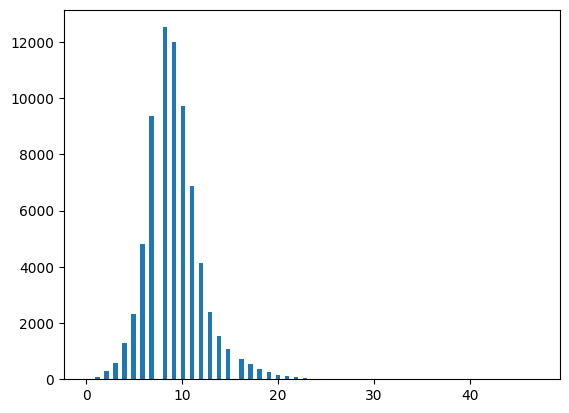

In [6]:
lengths = df_text['title'].apply(len)

# Calculate the median length
median_length = lengths.median()
max_length = lengths.max()
min_length = lengths.min()

truncate_length = max_length

print(min_length)
print(median_length)
print(max_length)
print(lengths.quantile(0.95))


plt.hist(lengths,bins=100)


In [8]:
# test with smaller amount of data
FRACTION = 0.01
size = int(df_text.shape[0] * FRACTION)
print(size)


# make tensors
def text_to_tensor(text_list, merged_keyed_vectors,truncate_length):
    vectors = [merged_keyed_vectors[word] for word in text_list[:truncate_length+1] if word in merged_keyed_vectors]
    return torch.tensor(vectors)


def stack_tensor(df: pd.DataFrame, col_name, word_model,truncate_length):
    tensor_ls = []
    label_ls = []
    for row in df.itertuples(index=False):
        # print(row[df.columns.get_loc('class')])
        # print(row[df.columns.get_loc(col_name)])
        label_ls.append(row[df.columns.get_loc("class")])
        tensor_ls.append(text_to_tensor(row[df.columns.get_loc(col_name)], word_model, truncate_length=truncate_length))
    padded_ls = pad_sequence(tensor_ls, batch_first=True)
    return torch.tensor(label_ls), torch.stack(tuple(padded_ls))


text_labels_tensor, text_tensor = stack_tensor(
    df_text.iloc[:size, :], 
    col_name="title", 
    word_model=merged_keyed_vectors,
    truncate_length=truncate_length
)
print(text_tensor.size())
print(text_labels_tensor.size())
text_dataset = TensorDataset(text_tensor, text_labels_tensor)

7142


/var/folders/nf/g_pc_4zd2sx16tjwwb4r4fhm0000gn/T/ipykernel_96503/2894886352.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(vectors)


torch.Size([7142, 30, 300])
torch.Size([7142])


In [9]:
def split(tensor_dataset, test_split=0.2):
    test_size = int(len(tensor_dataset) * test_split)
    train_size = int(len(tensor_dataset) - test_size)
    train_data, test_data = random_split(tensor_dataset, [train_size, test_size])
    print(f'total_size {len(tensor_dataset)}')
    print(f'train_size {len(train_data)}')
    print(f'test_size {len(test_data)}')
    return train_data, test_data

train_text_tensor, test_text_tensor = split(text_dataset,0.2)

with open("./data/train_title","wb") as f:
    pickle.dump(train_text_tensor,f)
with open("./data/test_title","wb") as f:
    pickle.dump(test_text_tensor,f)


total_size 7142
train_size 5714
test_size 1428
